In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

In [11]:
z = ParameterVector("z", 2)       # noise inputs
theta = ParameterVector("θ", 4)   # trainable parameters

qc = QuantumCircuit(2)
qc.ry(z[0], 0)
qc.ry(z[1], 1)
qc.ry(theta[0], 0)
qc.rz(theta[1], 0)
qc.ry(theta[2], 1)
qc.rz(theta[3], 1)
qc.cx(0, 1)

estimator = Estimator()
qnn_gen = EstimatorQNN(
    circuit=qc,
    input_params=[z[0], z[1]],
    weight_params=[theta[0], theta[1], theta[2], theta[3]],
    estimator=estimator,
)

generator_layer = TorchConnector(qnn_gen)

In [12]:
class QGANGenerator(nn.Module):
    def __init__(self):
        super(QGANGenerator, self).__init__()
        self.qnn = generator_layer

    def forward(self, z):
        return torch.tanh(self.qnn(z))  # squash into [-1, 1] range


gen_model = QGANGenerator()

In [13]:
class QGANDiscriminator(nn.Module):
    def __init__(self):
        super(QGANDiscriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        return self.net(x)

disc_model = QGANDiscriminator()

In [14]:
def main():
    num_epochs = 200
    batch_size = 16
    loss_G_history = []
    loss_D_history = []

    real_data = np.sin(np.linspace(0, 2 * np.pi, 100)).reshape(-1, 1)
    real_samples = torch.tensor(real_data, dtype=torch.float32)

    criterion = nn.BCEWithLogitsLoss()
    optimizer_G = optim.Adam(gen_model.parameters(), lr=0.005)
    optimizer_D = optim.Adam(disc_model.parameters(), lr=0.005)

    for epoch in range(num_epochs):

        optimizer_D.zero_grad()

        idx = np.random.randint(0, real_samples.shape[0], batch_size)
        real_batch = real_samples[idx] + 0.01 * torch.randn_like(real_samples[idx])  # small noise

        noise = torch.rand(batch_size, 2) * np.pi  # 2D noise
        fake_batch = gen_model(noise)

        pred_real = disc_model(real_batch)
        pred_fake = disc_model(fake_batch.detach())

        labels_real = torch.ones(batch_size, 1)
        labels_fake = torch.zeros(batch_size, 1)

        loss_D = criterion(pred_real, labels_real) + criterion(pred_fake, labels_fake)
        loss_D.backward()
        optimizer_D.step()

        for _ in range(4):
            optimizer_G.zero_grad()
            fake_batch = gen_model(noise)
            pred_fake = disc_model(fake_batch)
            loss_G = criterion(pred_fake, labels_real)  # want fakes classified as real
            loss_G.backward()
            optimizer_G.step()

        loss_G_history.append(loss_G.item())
        loss_D_history.append(loss_D.item())

        if epoch % 20 == 0:
            print(f"Epoch {epoch}: Loss_D = {loss_D.item():.4f}, Loss_G = {loss_G.item():.4f}")

    plt.figure(figsize=(8, 4))
    plt.plot(loss_D_history, label="Discriminator Loss")
    plt.plot(loss_G_history, label="Generator Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("QGAN Training Losses (2 Qubit Generator)")
    plt.show()


    test_noise = torch.linspace(0, np.pi, 100)
    test_inputs = torch.stack([test_noise, test_noise], dim=1)
    with torch.no_grad():
        gen_outputs = gen_model(test_inputs).numpy()

    plt.figure(figsize=(8, 4))
    plt.plot(real_data, 'b-', label="Real Data (sin)")
    plt.plot(gen_outputs, 'r--', label="Generated Data")
    plt.xlabel("Sample Index")
    plt.ylabel("Value")
    plt.legend()
    plt.title("2-Qubit QGAN: Generated Samples vs Real Sine Wave")
    plt.show()

Epoch 0: Loss_D = 1.3458, Loss_G = 0.7063
Epoch 20: Loss_D = 1.3593, Loss_G = 0.6981
Epoch 40: Loss_D = 1.4041, Loss_G = 0.6971
Epoch 60: Loss_D = 1.3633, Loss_G = 0.7581
Epoch 80: Loss_D = 1.3357, Loss_G = 0.7157
Epoch 100: Loss_D = 1.3536, Loss_G = 0.6910
Epoch 120: Loss_D = 1.4330, Loss_G = 0.6691
Epoch 140: Loss_D = 1.3413, Loss_G = 0.7290
Epoch 160: Loss_D = 1.3211, Loss_G = 0.7255
Epoch 180: Loss_D = 1.2778, Loss_G = 0.7246


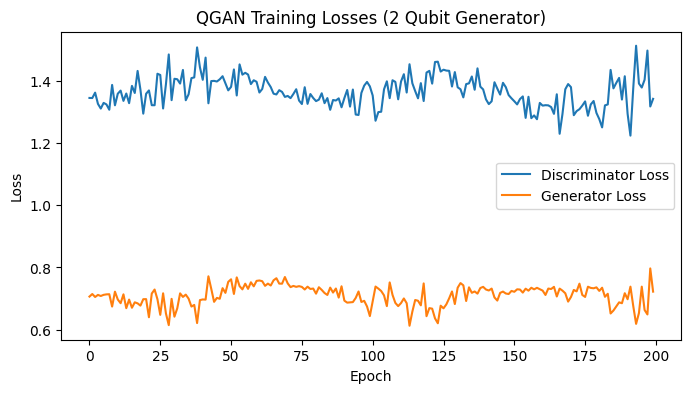

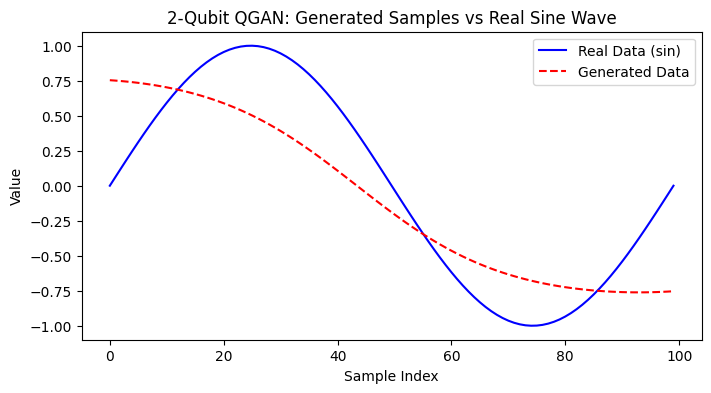

In [9]:
if __name__ == "__main__":
    main()